$\qquad$ $\qquad$$\qquad$  **TDA 231 Machine Learning: Homework 5** <br />
$\qquad$ $\qquad$$\qquad$ **Goal: Clustering**<br />
$\qquad$ $\qquad$$\qquad$                   **Grader: Aristide** <br />
$\qquad$ $\qquad$$\qquad$                     **Due Date: 21/5** <br />
$\qquad$ $\qquad$$\qquad$                   **Submitted by: Name, Personal no., email** <br />

General guidelines:
* Since there is no theoretical part for this assigment, submit this ipynb only (with completed code/results).
* All discussion regarding practical problems, along with solutions and plots should be specified here itself. We will not generate the solutions/plots again by running your code.
* Your name, personal number and email address should be specified above.
* All datasets can be downloaded from the course website.
* All plots/tables and other relevant information should be included.

# Practical problems

The follwing code might be useful for this excercise.

```python
import scipy.io
mat = scipy.io.loadmat('hw5_p1a.mat')
print (mat.keys())
X = mat['X']
```

## [K-Means Implementation, 20 points]

a. Implement the basic (linear) $k$-means algorithm as described in the lecture, using the euclidean distance. Use (uniformly) random points from the data as initialization for the centroids. Terminate the iterative procedure when the the cluster assignments do not change.

b. Run your implementation on the matrix $X$ in **hw5_p1a.mat** with $k=2$. Each row of the matrix is an observation, and each column is a feature. Store the cluster assignment both after 2 iterations, and at convergence. Produce a scatter plot of the data with colors indicating the cluster assignments at convergence and highlight points that have changed assignment after the second iteration.

c. Implement the kernel $k$-means algorithm as described in the lecture, using the Gaussian RBF-kernel.

d. Run the linear $k$-means **and** your kernel $k$-means on **hw5_p1b.mat** with $k=2$. For the Gaussian RBF-kernel, use $\sigma=0.2$. Produce scatter plots of the data, with color indicating the cluster assignment at convergence, one plot for each of the algorithms.

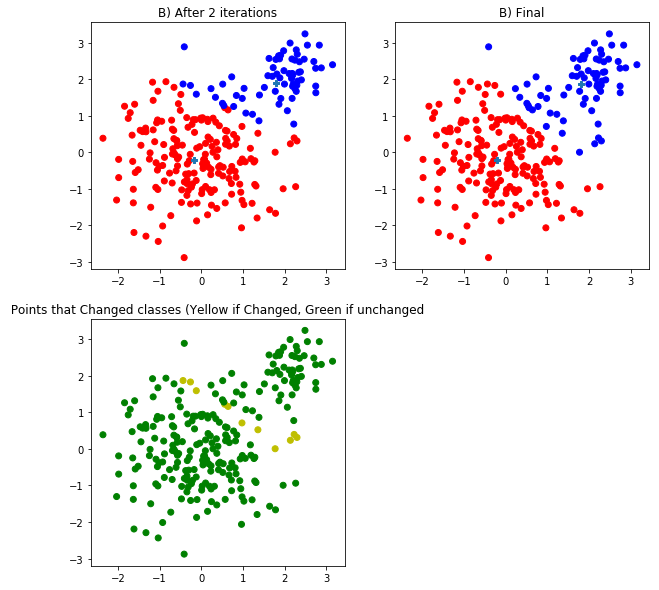

In [20]:
import scipy.io
import numpy as np
import copy
import matplotlib.pyplot as plt

mat = scipy.io.loadmat('hw5_p1a.mat')
X = mat['X']

################################################## a) b) #############################################
def k_means(X, K):
    # Calculates new mu as given in lecture notes 
    def new_mu(z,k,x):
        numerator = np.zeros(2)
        for i in range(0,len(x)):
            numerator += x[i] * z[k][i]

        d = 0
        for j in range(0,len(z[k])):
            d += z[k][j]

        return numerator / d

    # FOR B) store cluster assignments after 2 iterations and convergence
    iterations = 0
    clusters = []
    
    # Define z as the centriods for which the points are assigned to
    z = {}
    for i in range(0,K):
        z[i] = {}

    # Define mu as the centroids
    mu = []

    # Guess their centroids by taking a random point
    for i in range(0,K):
        index = int(round(np.random.uniform() * 10))
        mu.append(X[index])
        
    #centroid after 2 iteration
    mu_2 = []

    # Run until the mu's are not changed anymore
    while True:
        
        # Increament iterations
        iterations += 1

        # Create a deep copy of z to compare with if z has changed
        z_n = copy.deepcopy(z)
        mu_n = copy.deepcopy(mu)

        # Calculate the distance from every point to each mu's
        for i in range(0, len(X)):
            p = X[i]

            # Define a m_short to indicate which mu that had shortest distance to point p
            mu_short = {
               "dis": 99,
               "index": -1
            }

            # Calculate which mu has shortest distance
            for m_i in range(0,len(mu)):
                dis = np.linalg.norm(p-mu[m_i])
                if dis < mu_short["dis"]:
                    mu_short["dis"] = dis
                    mu_short["index"] = m_i

            # Assign the point to the closest mu
            z[mu_short["index"]][i] = 1

            # Assign 0 to every other mu for this point 
            for k in range(0,K):
                if not (mu_short["index"] == k):
                    z[k][i] = 0

        # Calculate new mu's
        for k in range(0,K):
            mu[k] = new_mu(z,k,X)

        # Check if z's or mu's are equal is different
        if np.array_equal(z, z_n) or np.array_equal(mu, mu_n):
            break
            
        # FOR B) store clusters (z)
        if iterations == 2:
            clusters.append(z_n)
            mu_2 = copy.deepcopy(mu)
        
    # FOR B) store clusters at convergence
    clusters.append(z)
        
    # At this point, the mu's are "optimal" (could be local optimum)
    return mu, z, clusters, mu_2

mu, z, clusters, mu_2 = k_means(X,2)

# Plot when 2 iterations
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax1.set_title("B) After 2 iterations")
colors_1 = []
for i in range(0, len(clusters[0][0])):
    if clusters[0][0][i] == 1:
        colors_1.append("r")
    else:
        colors_1.append("b")
ax1.scatter(X[:,0],X[:,1],color=colors_1)


ax1.scatter([i[0] for i in mu_2], [i[1] for i in mu_2], marker = "P")

# Plot when convergence reached
ax2 = fig.add_subplot(222)
ax2.set_title("B) Final")
colors_2 = []
for i in range(0, len(clusters[1][0])):
    if clusters[1][0][i] == 1:
        colors_2.append("r")
    else:
        colors_2.append("b")
ax2.scatter(X[:,0],X[:,1],color=colors_2)
ax2.scatter([i[0] for i in mu], [i[1] for i in mu], marker = "P")

# plot to see the difference between after 2 iterations and after convergence

ax4 = fig.add_subplot(223)
ax4.set_title(" Points that Changed classes (Yellow if Changed, Green if unchanged ")
colors_3 = []
for i in range(0, len(clusters[1][0])):
    if ((clusters[0][0][i] == 1) and (clusters [1][0][i] == 0)) or ((clusters[0][1][i] == 1) and (clusters [1][1][i] == 0)):
        colors_3.append("y")
    else:
        colors_3.append("g")
        
ax4.scatter(X[:,0],X[:,1],color=colors_3)
                                         
                                         


################
# Show 
plt.show()

################################################## c) #############################################
mat = scipy.io.loadmat('hw5_p1b.mat')
Y = mat['X']

def kernal_k_means(X, K, sigma):

    # Data length
    length = len(X)
    
    # RBF Kernal
    def rbf(x1, x2, sigma):
        delta = abs(np.subtract(x1, x2))
        squaredEuclidean = np.square(delta)
        result = np.exp(-(squaredEuclidean)/(2*sigma**2))
        return result

    # Second term of the distance function defined in lecture notes
    def snd_term(x, Nk, X, z, k):
        r = 0
        l = len(z[k])
        for m in range(0, l):
            r += z[k][m]*rbf(x, X[m])

        return (2*r) / Nk

    # Third term of the distance function defined in lecture notes
    def td_term(Nk, X, z, k):
        r = 0
        lt = len(z[k])
        for m in range(0, lt):
            for l in range(0, l):
                r += z[k][m]*z[k][l]*rbf(X[m], X[l])

        return r / (2*Nk)

    # Sum of number of points assigned to the k'th z
    def Nk(z,k):
        return sum(z[k])

    # Create's K number of dictionaries to map the points
    def initZ(K):
        # Define z as the centriods for which the points are assigned to
        z = {}
        for k in range(0,K):
            z[k] = {}
            # Assign random points to z_nk
            for n in range(0,length):
                if np.random.uniform() > 0.5:
                    z[k][n] = 1
                else:
                    z[k][n] = 0
        return z

    # Distance function as defined in lecture notes
    def distance(x, Nk, data, z, k, sigma):
        return rbf(x, x, sigma) - snd_term(x, Nk, data, z, k) + td_term(Nk, data, z, k)

    # Create the z's
    z = initZ(K)

    while (True):

        # Create a deepcopy of latest z
        z_n = copy.deepcopy(z)

        # For each point in X, assign it to the center with nereast distance
        for i in len(X):
            x = X[i]
            nearest = { "k": -1, "dis": 99 }
            for k in range(0,K):
                d = distance(x, Nk(z,k))
                if d < nearest["dis"]:
                    nearest["k"] = k
            
            # Assign 1 to nearest, 0 to others
            z[nearest["k"]][i] = 1
            for k_n in range(0, K):
                if not k_n == nearest["k"]:
                    z[k_n][i] = 0

        # Check if z is 
        if np.array_equal(z, z_n):
            break


In [ ]:
import scipy.io
import numpy as np
import copy
import matplotlib.pyplot as plt
import sys

mat = scipy.io.loadmat('hw5_p1a.mat')
X = mat['X']

################################################## a) b) #############################################
def k_means(X, K):
    # Calculates new mu as given in lecture notes 
    def new_mu(z,k,x):
        numerator = np.zeros(2)
        for i in range(0,len(x)):
            numerator += x[i] * z[k][i]

        d = 0
        for j in range(0,len(z[k])):
            d += z[k][j]

        return numerator / d

    # FOR B) store cluster assignments after 2 iterations and convergence
    iterations = 0
    clusters = []
    
    # Define z as the centriods for which the points are assigned to
    z = {}
    for i in range(0,K):
        z[i] = {}

    # Define mu as the centroids
    mu = []

    # Guess their centroids by taking a random point
    for i in range(0,K):
        index = int(round(np.random.uniform() * 10))
        mu.append(X[index])

    # Run until the mu's are not changed anymore
    while True:
        
        # Increament iterations
        iterations += 1

        # Create a deep copy of z to compare with if z has changed
        z_n = copy.deepcopy(z)
        mu_n = copy.deepcopy(mu)

        # Calculate the distance from every point to each mu's
        for i in range(0, len(X)):
            p = X[i]

            # Define a m_short to indicate which mu that had shortest distance to point p
            mu_short = {
               "dis": 99,
               "index": -1
            }

            # Calculate which mu has shortest distance
            for m_i in range(0,len(mu)):
                dis = np.linalg.norm(p-mu[m_i])
                if dis < mu_short["dis"]:
                    mu_short["dis"] = dis
                    mu_short["index"] = m_i

            # Assign the point to the closest mu
            z[mu_short["index"]][i] = 1

            # Assign 0 to every other mu for this point 
            for k in range(0,K):
                if not (mu_short["index"] == k):
                    z[k][i] = 0

        # Calculate new mu's
        for k in range(0,K):
            mu[k] = new_mu(z,k,X)

        # Check if z's or mu's are equal is different
        if np.array_equal(z, z_n) or np.array_equal(mu, mu_n):
            break
            
        # FOR B) store clusters (z)
        if iterations == 2:
            clusters.append(z_n)
        
    # FOR B) store clusters at convergence
    clusters.append(z)
        
    # At this point, the mu's are "optimal" (could be local optimum)
    return mu, z, clusters

# mu, z, clusters = k_means(X,2)

# # Plot when 2 iterations
# fig = plt.figure(figsize=(10,10))
# ax1 = fig.add_subplot(221)
# ax1.set_title("B) After 2 iterations")
# colors_1 = []
# for i in range(0, len(clusters[0][0])):
#     if clusters[0][0][i] == 1:
#         colors_1.append("r")
#     else:
#         colors_1.append("b")
# ax1.scatter(X[:,0],X[:,1],color=colors_1)

# # Plot when convergence reached
# ax2 = fig.add_subplot(222)
# ax2.set_title("B) Final")
# colors_2 = []
# for i in range(0, len(clusters[1][0])):
#     if clusters[1][0][i] == 1:
#         colors_2.append("r")
#     else:
#         colors_2.append("b")
# ax2.scatter(X[:,0],X[:,1],color=colors_2)

# ###############
# plt.show()

################################################## c) #############################################
mat = scipy.io.loadmat('hw5_p1b.mat')
Y = mat['X']

class Kernal_k_means:

    def __init__(self, data, K, sigma):
        # Will store certain computations
        self.comp = {}
        
        self.X = data
        self.K = K
        self.sigma = sigma
        self.length = len(data)
        self.iterations = 0
        self.plots = 0

        self.z = self.initZ()
        self.fig = plt.figure(figsize=(10, 10))
        self.temp =0

    def hash(self,x):
        return hash(str(x[0])+str(x[1]))

    # Create's K number of dictionaries to map the points
    def initZ(self):
        # Define z as the centriods for which the points are assigned to
        z = []
        for k in range(0, self.K):
            z.append([])
            # Assign random points to z_nk
            for n in range(0, self.length):
                if np.random.uniform() > 0.5:
                    z[k].append(1)
                else:
                    z[k].append(0)
        return np.array(z)
    
    # RBF Kernal
    def rbf(self, x1, x2):
        delta = abs(np.subtract(x1,x2))
        se = np.square(delta).sum(axis=0)
        result = np.exp(-(se)/(2*self.sigma**2))
        return result

    # # There is a part that both 2nd and 3rd term uses: sum_i=1^N k(x, X[i])
    # # Since both uses it, we explicitly define it here.
    # # Returns a vector for the point x like [K(x, X_1), K(x, X_2), ..., K(x, X_n)]
    # def part_snd(self, x):

    #     # Compute if not already computed
    #     if self.hash(x) in self.comp["snd"]:
    #         return self.comp["snd"][self.hash(x)]

    #     r = []
    #     for m in range(0, self.length):
    #         r.append(self.rbf(x, self.X[m]))
        
    #     self.comp["snd"][self.hash(x)] = np.array(r)

    #     return self.comp["snd"][self.hash(x)]

    def prepare_kernal(self):

        for xi in self.X:
            r = []
            for xj in self.X:
                r.append(self.rbf(xi, xj))

            self.comp[self.hash(xi)] = np.array(r)


    # Second term of the distance function defined in lecture notes
    def snd_term(self, x, k):
        
        res = np.dot(self.z[k], self.comp[self.hash(x)])

        return (2*res) / self.Nk(k)

    # Third term of the distance function defined in lecture notes
    def td_term(self, k):

        # # Check if already computed
        # if len(self.comp["thd"]) == 0:
        #     r = []
        #     for m in range(0, self.length):
        #         # The vector for the point X[m] might already been computed before.
        #         # Therefore we use part_snd
        #         r.append(self.part_snd_two(X[m]))

        #     # Store computation
        #     self.comp["thd"] = np.array(r)

        # Create a 2D matrix of z_mk and z_lk. The same as taking z_k * z_k^T
        zk = np.outer(self.z[k], self.z[k])

        # Take the dot product of first row of zk and first row of comp["thd"] to compute the sum
        # in the third term 
        numerator = 0
        for i in range(0,self.length):
            numerator += np.dot(zk[i], self.comp[self.hash(self.X[i])])

        return numerator / (2*self.Nk(k))

    # Sum of number of points assigned to the k'th z
    def Nk(self,k):
        sumZk = np.sum(self.z[k])
        return sumZk

    # Distance function as defined in lecture notes
    def distance(self, x, k):
        stm = self.snd_term(x, k)
        ttm = self.td_term(k)
        return 1 - stm + ttm

    def plot(self):
        # Plot when convergence reached
        ax = self.fig.add_subplot(222+self.plots)
        ax.set_title("Iteration " + str(self.iterations))
        colors = []
        for i in range(0, self.length):
            if self.z[0][i] == 1:
                colors.append("r")
            else:
                colors.append("b")
        ax.scatter(self.X[:, 0], self.X[:, 1], color=colors)
        self.plots += 1

    def calculate(self):

        # Prepare computations
        self.prepare_kernal()

        # Compute until nothing changes anymore
        while (True):

            # Define a z to compare with
            z_n = copy.deepcopy(self.z)

            for i in range(0,self.length):
                x = self.X[i]
                s = {"index": -1, "dis": 9999}
                for k in range(0, self.K):
                    d = self.distance(x,k)
                    if d < s["dis"]:
                        s["dis"] = d
                        s["index"] = k
                
                self.z[s["index"]][i] = 1

                for l in range(0, self.K):
                    if not l == s["index"]:
                        self.z[l][i] = 0

            if np.array_equal(self.z,z_n):
                break

            # Increase number of iterations
            self.iterations += 1

            # Plot when 5
            # if self.iterations % 5 == 0:
            #     self.plot()

            # Stop when 10 iterations
#             if self.iterations == 35:
#                 break

        # Show the plots
        # plt.show()

        return self.z

km = Kernal_k_means(Y,2,0.2)
z = km.calculate()

# Plot when convergence reached
fig = plt.figure(figsize=(10, 10))
ax2 = fig.add_subplot(222)
ax2.set_title("C) Final")
colors_2 = []
for i in range(0, km.length):
    if z[1][i] == 1:
        colors_2.append("r")
    else:
        colors_2.append("b")
ax2.scatter(Y[:,0],Y[:,1],color=colors_2)

###############
# Show
plt.show()

# t = 0
# for k1 in km.comp["snd"].keys():
#     for k2 in km.comp["snd"].keys():
#         if k1 == k2:
#             t += 1
#             print(t)